In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [4]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print (len(df))

9779168


In [5]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão DEZ a MAR
print (len(df))
df.sample(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
1475516,317,MONTE VERDE,1545.0,-22.861604,-46.043365,A509,Camanducaia,MG,2015-01-16 20:00:00,2015-01-16,...,26.8,15.8,25.8,10.7,39.0,52.0,38.0,1.9,111.0,5.5
9461876,419,BARRA DO TURVO,660.0,-24.962819,-48.416379,A746,Barra do Turvo,SP,2009-01-01 12:00:00,2009-01-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6789883,384,VILA MILITAR,30.0,-22.861322,-43.411410,A621,Rio de Janeiro,RJ,2009-01-11 11:00:00,2009-01-11,...,26.9,21.8,25.6,20.7,70.0,77.0,70.0,1.6,46.0,3.0


In [6]:
df = df.sort_values(['wsid', 'mdct'])
df = df.reset_index(drop=True)

In [7]:
#df = df[(df['lat'].between(-20.5,-19.0, inclusive=True)) & 
#        (df['lon'].between(-44.5,-43.0, inclusive=True))] 

In [8]:
df = df[df['wsid']==329]
print (len(df))

29112


In [9]:
df.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
816792,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 00:00:00,2006-12-01,...,20.7,20.5,20.4,20.2,99.0,99.0,98.0,1.0,121.0,2.6
816793,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 01:00:00,2006-12-01,...,20.9,20.6,20.7,20.5,98.0,99.0,98.0,1.2,146.0,2.0
816794,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 02:00:00,2006-12-01,...,20.9,20.6,20.5,20.3,98.0,98.0,98.0,0.5,309.0,2.0
816795,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 03:00:00,2006-12-01,...,20.7,20.5,20.6,20.3,98.0,98.0,98.0,NaN,356.0,0.9


# Pré-processamento

<h3>Dados ausentes</h3>

In [10]:
missing_values_count = (df.isnull().sum()/len(df))*100

In [11]:
missing_values_count[missing_values_count > 0.1]

prcp    86.723688
gbrd    41.872767
wdsp     5.021984
gust     1.329349
dtype: float64

<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [12]:
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [13]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [14]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)

In [15]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

Series([], dtype: float64)

<p>Alguns campos estão com pouquissimos valores nulos.</p>

In [16]:
DES = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date','yr','mo','da','hr']

In [17]:
V = [x for x in df.columns if x not in DES]
#df[V].describe().T

<p><b>PRONTO! Dados recuperados!</b> Agora vamos a etapa de limpeza</p>

<h3>Limpeza dos dados</h3>

In [18]:
backup_df = df.copy

<p>Alguns campos podem ser nulos</p>

In [19]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [20]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,29112.0,0.380702,2.269639,0.0,0.0,0.0,0.0,78.4
stp,29112.0,908.517257,89.239876,0.0,915.8,917.4,918.9,924.2
smax,29112.0,908.700110,89.580653,0.0,916.0,917.7,919.1,924.3
smin,29112.0,908.207399,89.532850,0.0,915.5,917.2,918.6,924.2
temp,29112.0,23.124210,3.927019,0.0,20.7,22.7,25.7,33.9
tmax,29112.0,17.124471,2.524743,0.0,16.1,17.5,18.7,22.6
tmin,29112.0,23.777490,4.147014,0.0,21.1,23.4,26.6,35.1
dewp,29112.0,17.726384,2.565495,0.0,16.7,18.0,19.2,23.6
dmax,29112.0,22.487236,3.703314,0.0,20.3,22.1,24.8,32.4
dmin,29112.0,16.565873,2.555016,0.0,15.5,17.0,18.2,21.6


In [21]:
df[cols] = df[cols].replace({0.0:np.nan})

In [22]:
print (len(df))
df  = df.dropna()
print (len(df))

29112
28832


<p>Verificando os mínimos e máximos por região.</p>

In [23]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,28832.0,0.384399,2.280322,0.0,0.0,0.0,0.0,78.4
stp,28832.0,917.276554,2.343445,906.5,915.8,917.4,918.9,924.2
smax,28832.0,917.524889,2.322062,906.7,916.1,917.7,919.1,924.3
smin,28832.0,917.027393,2.350573,906.4,915.6,917.2,918.6,924.2
temp,28832.0,23.347035,3.219508,15.3,20.7,22.8,25.7,33.9
tmax,28832.0,17.289442,1.892367,6.6,16.1,17.5,18.7,22.6
tmin,28832.0,24.008404,3.438123,16.4,21.2,23.4,26.6,35.1
dewp,28832.0,17.898533,1.887954,6.7,16.7,18.1,19.2,23.6
dmax,28832.0,22.705619,2.981447,15.0,20.3,22.1,24.9,32.4
dmin,28832.0,16.726752,1.974954,5.3,15.6,17.0,18.2,21.6


<p>Algumas regras:</p>
<ul>
   <li>Max > Min: para temperatura, humidade, pressão e ponto de orvalho</li>
   <li>Mínima para região é possivel?</li>
   <li>Máxima para região é possivel?</li>
</ul>

<p>Vamos a temperatura máxima e mínima</p>

In [24]:
x = df[(df['tmin'] > df['tmax'])]
print ('tmin>tmax',x)
x = df[(df['hmin'] > df['hmax'])]
print ('hmin>hmax',x)
x = df[(df['smin'] > df['smax'])]
print ('smin>smax',x)
x = df[(df['dmin'] > df['dmax'])]
print ('dmin>dmax',x)

tmin>tmax         wsid                  wsnm   elvt        lat        lon  inme  \
816792   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816793   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816794   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816795   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816796   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816797   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816798   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816799   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816800   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816801   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816802   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816803   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816804   329  BELO HOR. (PAMPULHA)  854.0

<h4>Outliers</h4>

<p>Usando boxplot para verificar se existem outliers</p> 

In [25]:
sns.set_style("whitegrid")

<p>Pressão atmosférica</p>

In [26]:
sns.set(font_scale=2) 
def bp(var):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    #sns.boxplot(x='prov',y=var, data=df, ax=ax)
    ax = sns.distplot(df[var])
    ax2 = ax.twinx()
    sns.boxplot(x=df[var], ax=ax2)
    ax2.set(ylim=(-.5, 10))
    ax.set_title('Com outliers: ' + var)
def bp_sem(var):
    q = df[var].quantile(0.99)
    x_filt = df[df[var] < q]
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    ax = sns.distplot(x_filt[var])    
    ax.set_title('Sem outliers: ' + var)

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


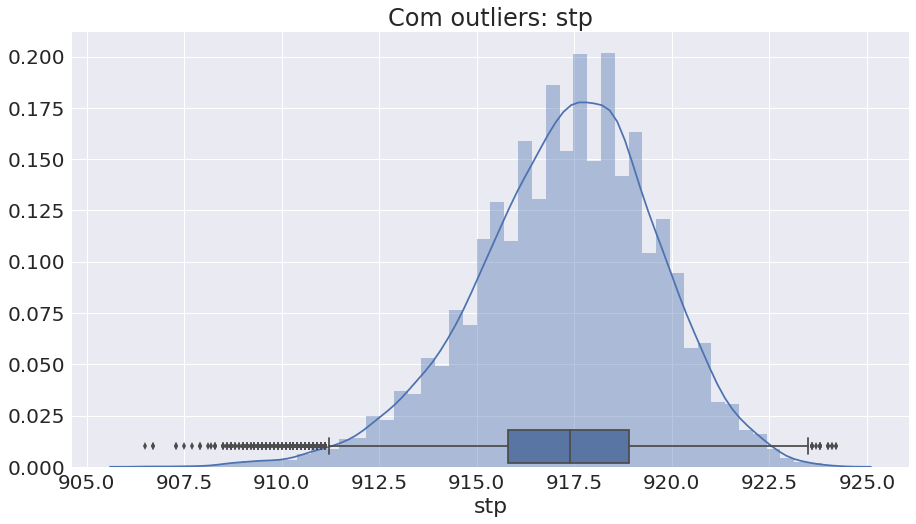

In [27]:
bp('stp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


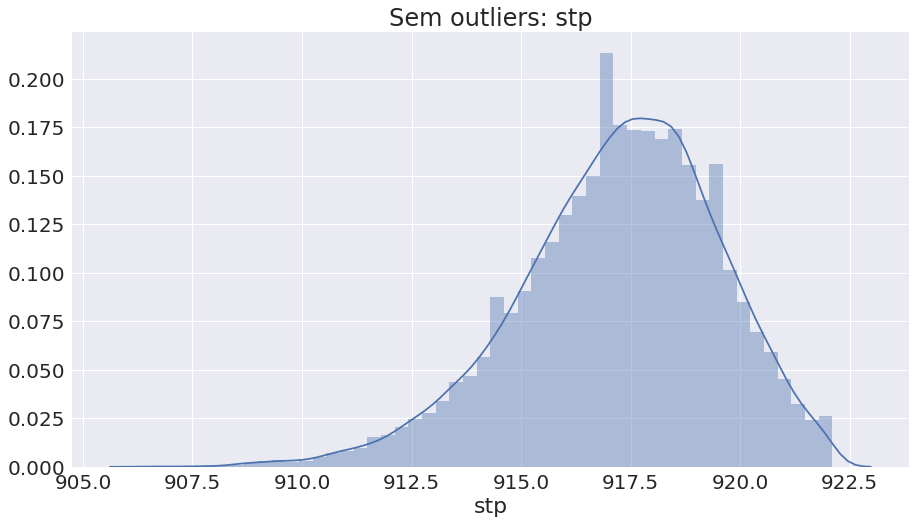

In [28]:
bp_sem('stp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


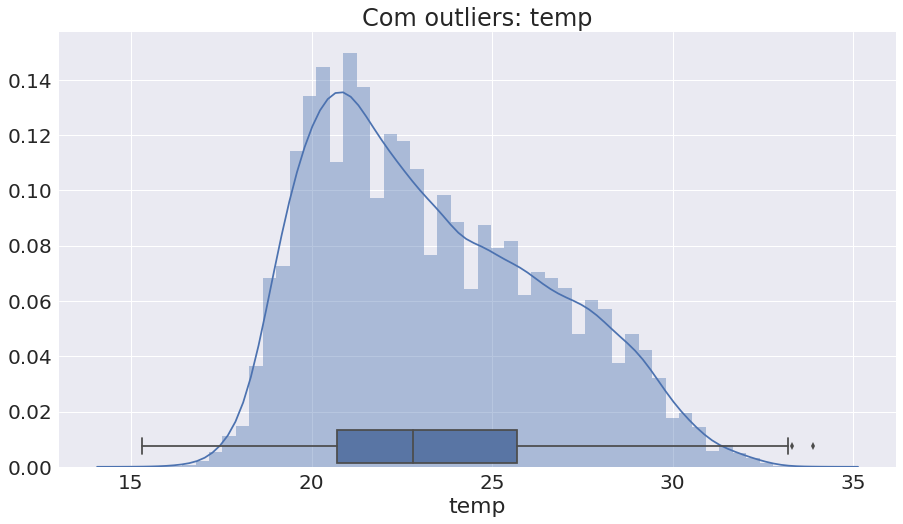

In [29]:
bp('temp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


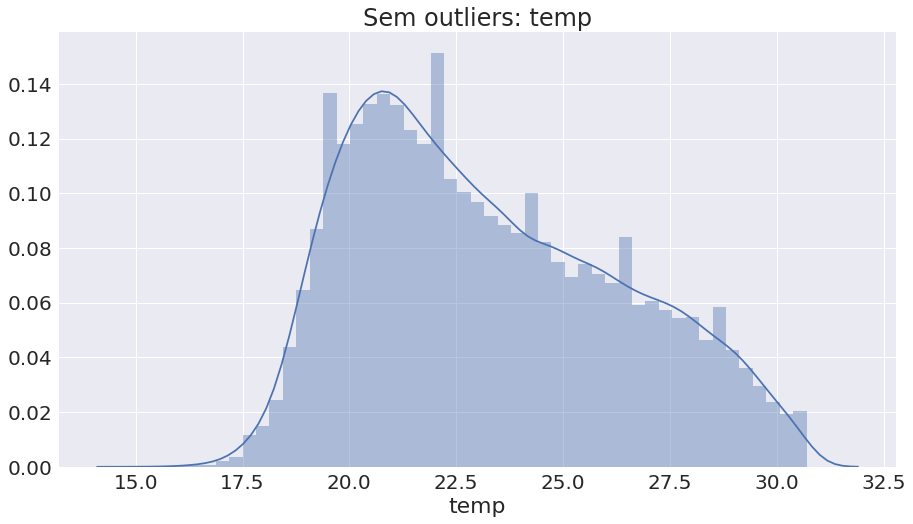

In [30]:
bp_sem('temp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


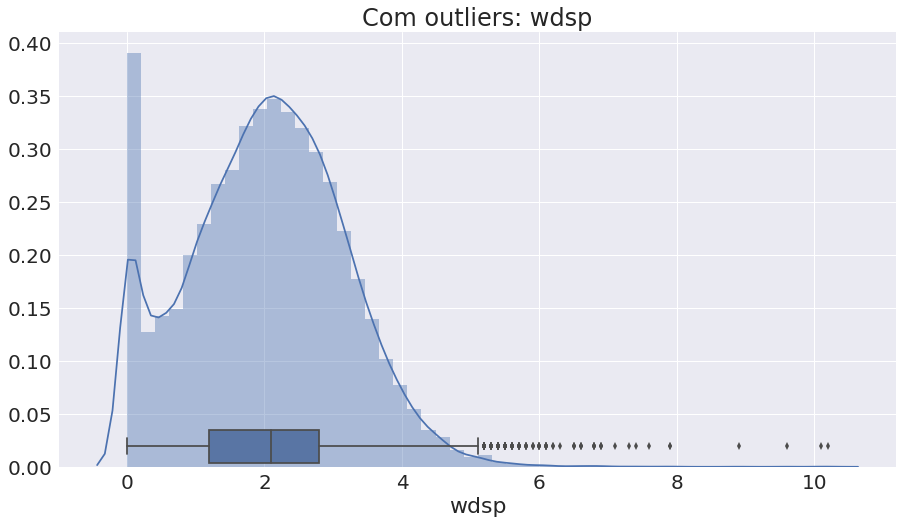

In [31]:
bp('wdsp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


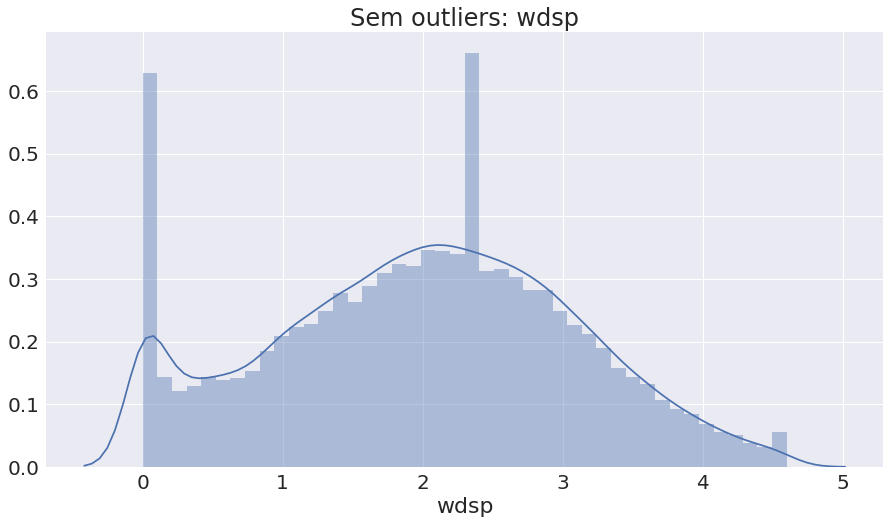

In [32]:
bp_sem('wdsp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


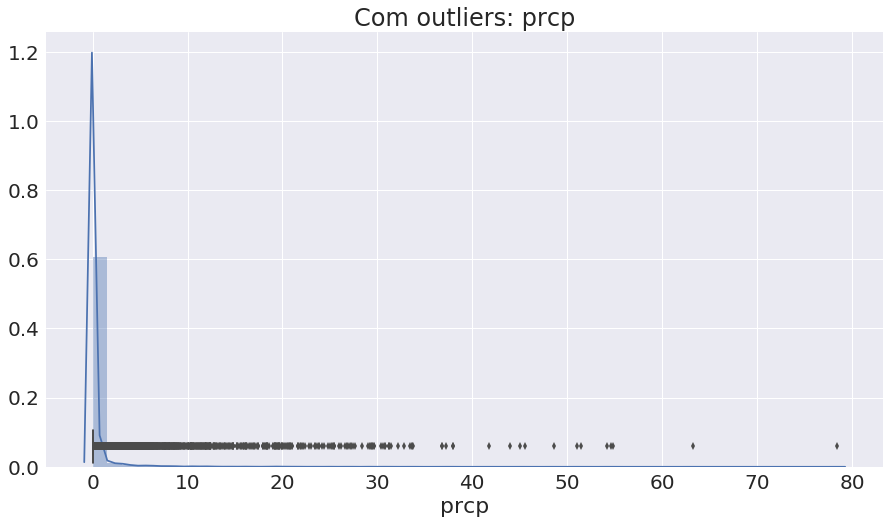

In [33]:
bp('prcp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


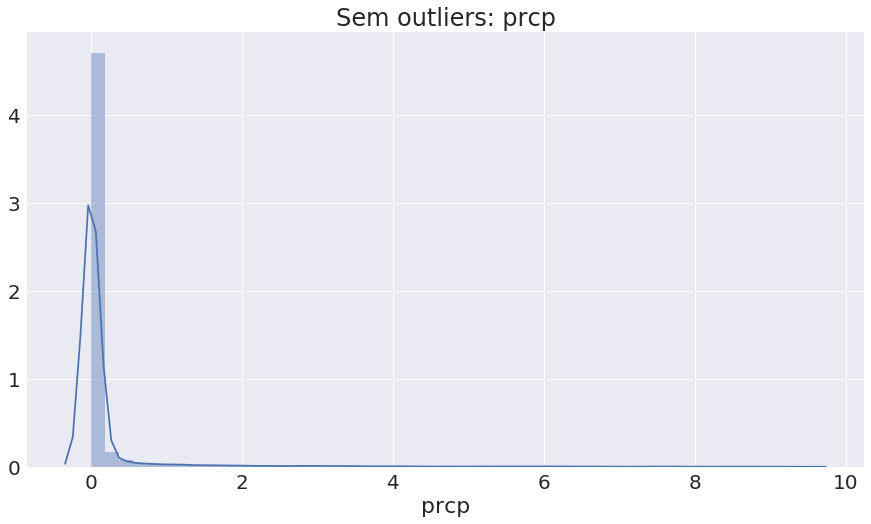

In [34]:
bp_sem('prcp')

<h3>Derivando novas variáveis (Feature engineering)</h3>

<p>Recuperando o backup do dataframe antes da limpeza dos nulos, pois preciso derivar as freatures primeiro.
Assim, após a derivá-las, irei apagar os que não pode ser nulo. Esta etapa teve que ser feita de novo, por este motivo</p> 

In [35]:
dfm = backup_df() 

In [36]:
len(dfm)

29112

In [37]:
dfm = dfm.drop('wdsp',1)
dfm = dfm.drop('wdct',1)
dfm = dfm.drop('gust',1)

<p>Conforme o Zarate orientou retirando o vento pois precisa ser modelado de forma diferente</p> 

In [38]:
CLEAN = ['wsnm','inme','city','prov','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.sample(5)  

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin
823639,329,854.0,-19.883945,-43.969397,2009-01-12 07:00:00,0.0,919.7,920.5,919.7,20.0,16.6,20.7,16.6,20.0,16.4,81.0,81.0,77.0
834003,329,854.0,-19.883945,-43.969397,2012-03-21 03:00:00,0.0,918.0,918.4,918.0,19.2,17.3,19.4,17.4,19.2,17.3,89.0,89.0,88.0
819024,329,854.0,-19.883945,-43.969397,2007-03-04 00:00:00,0.0,920.3,920.3,919.6,23.1,16.6,23.6,16.6,23.0,16.2,67.0,67.0,64.0
838724,329,854.0,-19.883945,-43.969397,2014-02-03 20:00:00,0.0,916.5,916.5,916.3,28.6,12.8,29.8,13.8,28.4,11.9,38.0,40.0,34.0
838080,329,854.0,-19.883945,-43.969397,2014-01-08 00:00:00,0.0,918.0,918.1,917.8,22.8,11.7,23.5,12.3,22.8,11.7,49.0,51.0,48.0


In [39]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print (ws)

[329]


In [40]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [41]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,24,NON_DER)

In [42]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [43]:
cols = {}
for v,i in var:
    x = '{}_{}'.format(v, i)
    if int(i) not in cols:
        cols[int(i)] = [x]
    else:
        cols[int(i)].append(x)
#print cols

In [44]:
xxx = dfr.copy()

In [45]:
# Inicializando
xxx['prcp_acum_24'] = 99.99
xxx['prcp_plus_12'] = 99.99

In [46]:
for w in ws:
    
    size = xxx.loc[xxx['wsid'].isin([w])].iloc[:]['prcp'].count()
    
    pos_prcp = xxx.columns.get_loc('prcp')
    
    pos_acum_6 = xxx.columns.get_loc('prcp_acum_24')
    pos_plus_1 = xxx.columns.get_loc('prcp_plus_12')
    
    j=11
    
    for i in range(0,size):
        idx = xxx.loc[xxx['wsid'].isin([w])].index
        xxx.loc[xxx.loc[idx,'prcp_acum_24'].index[i],'prcp_acum_24'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+24,pos_prcp].sum()
        if i+12 < size:
            xxx.loc[xxx.loc[idx,'prcp_plus_12'].index[i],'prcp_plus_12'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+12,pos_prcp].sum()
        else:
            xxx.loc[xxx.loc[idx,'prcp_plus_12'].index[i],'prcp_plus_12']  = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+j,pos_prcp].sum()
            j-=1

In [47]:
dfr = xxx 

In [48]:
dfr.head(12)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,hmin_17,hmin_18,hmin_19,hmin_20,hmin_21,hmin_22,hmin_23,hmin_24,prcp_acum_24,prcp_plus_12
816792,329,854.0,-19.883945,-43.969397,2006-12-01 00:00:00,0.0,915.4,915.4,914.0,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.8,15.2
816793,329,854.0,-19.883945,-43.969397,2006-12-01 01:00:00,0.0,916.0,916.0,915.4,20.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.8,15.2
816794,329,854.0,-19.883945,-43.969397,2006-12-01 02:00:00,0.4,916.0,916.2,916.0,20.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.2,15.4
816795,329,854.0,-19.883945,-43.969397,2006-12-01 03:00:00,1.8,915.1,916.0,915.1,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.8,15.0
816796,329,854.0,-19.883945,-43.969397,2006-12-01 04:00:00,12.4,914.4,915.2,914.4,20.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,13.6
816797,329,854.0,-19.883945,-43.969397,2006-12-01 05:00:00,0.6,913.8,914.4,913.8,20.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,1.2
816798,329,854.0,-19.883945,-43.969397,2006-12-01 06:00:00,0.0,913.5,913.8,913.4,20.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816799,329,854.0,-19.883945,-43.969397,2006-12-01 07:00:00,0.0,913.4,913.6,913.4,20.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816800,329,854.0,-19.883945,-43.969397,2006-12-01 08:00:00,0.0,914.2,914.2,913.4,20.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816801,329,854.0,-19.883945,-43.969397,2006-12-01 09:00:00,0.0,915.0,915.0,914.2,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,0.6


In [49]:
dfr.columns

Index(['wsid', 'elvt', 'lat', 'lon', 'mdct', 'prcp', 'stp', 'smax', 'smin',
       'temp',
       ...
       'hmin_17', 'hmin_18', 'hmin_19', 'hmin_20', 'hmin_21', 'hmin_22',
       'hmin_23', 'hmin_24', 'prcp_acum_24', 'prcp_plus_12'],
      dtype='object', length=356)

In [50]:
dfm = dfr

In [51]:
list(dfm.columns)

['wsid',
 'elvt',
 'lat',
 'lon',
 'mdct',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'hmax_7',
 'hmax_8',
 'hmax_9',
 'hmax_10',
 'hmax_11',
 'hmax_12',
 'hmax_13',
 'hmax_14',
 'hmax_15',
 'hmax_16',
 'hmax_17',
 'hmax_18',
 'hmax_19',
 'hmax_20',
 'hmax_21',
 'hmax_22',
 'hmax_23',
 'hmax_24',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 'mdct_5',
 'mdct_6',
 'mdct_7',
 'mdct_8',
 'mdct_9',
 'mdct_10',
 'mdct_11',
 'mdct_12',
 'mdct_13',
 'mdct_14',
 'mdct_15',
 'mdct_16',
 'mdct_17',
 'mdct_18',
 'mdct_19',
 'mdct_20',
 'mdct_21',
 'mdct_22',
 'mdct_23',
 'mdct_24',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'temp_7',
 'temp_8',
 'temp_9',
 'temp_10',
 'temp_11',
 'temp_12',
 'temp_13',
 'temp_14',
 'temp_15',
 'temp_16',
 'temp_17',
 'temp_18',
 'temp_19',
 'temp_20',
 'temp_21',
 'temp_22',
 'temp_23',
 'temp_24',
 'sm

In [52]:
len(dfm)

29112

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [53]:
cols = list(df.columns)
for v in ['wdsp','wdct','gust']:
    cols.remove(v)

In [54]:
COLS_BE_NULL = ['prcp'] + DES + ['temp']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin']

In [55]:
dfm[cols] = dfm[cols].replace({0.0:np.nan}) 

In [56]:
print (len(dfm))
dfm  = dfm.dropna()
print (len(dfm))

29112
27721


In [57]:
dfm = dfm.reset_index(drop=True)

In [58]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,hmin_17,hmin_18,hmin_19,hmin_20,hmin_21,hmin_22,hmin_23,hmin_24,prcp_acum_24,prcp_plus_12
0,329,854.0,-19.883945,-43.969397,2006-12-02 00:00:00,0.0,918.2,918.2,917.5,18.8,...,90.0,88.0,92.0,98.0,98.0,98.0,98.0,98.0,2.0,2.0
1,329,854.0,-19.883945,-43.969397,2006-12-02 01:00:00,0.4,918.7,918.7,918.2,18.6,...,92.0,90.0,88.0,92.0,98.0,98.0,98.0,98.0,2.0,2.0
2,329,854.0,-19.883945,-43.969397,2006-12-02 02:00:00,1.0,918.7,918.8,918.7,18.4,...,92.0,92.0,90.0,88.0,92.0,98.0,98.0,98.0,1.6,1.6
3,329,854.0,-19.883945,-43.969397,2006-12-02 03:00:00,0.2,918.1,918.7,918.1,18.6,...,86.0,92.0,92.0,90.0,88.0,92.0,98.0,98.0,0.6,0.6
4,329,854.0,-19.883945,-43.969397,2006-12-02 04:00:00,0.0,917.3,918.1,917.3,18.7,...,84.0,86.0,92.0,92.0,90.0,88.0,92.0,98.0,0.4,0.4


In [59]:
dfm.to_csv('../data/derivaded.csv')

In [60]:
dfm = dfm.drop('wsid',1)
dfm = dfm.drop('mdct',1)

In [61]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'hmax_7',
 'hmax_8',
 'hmax_9',
 'hmax_10',
 'hmax_11',
 'hmax_12',
 'hmax_13',
 'hmax_14',
 'hmax_15',
 'hmax_16',
 'hmax_17',
 'hmax_18',
 'hmax_19',
 'hmax_20',
 'hmax_21',
 'hmax_22',
 'hmax_23',
 'hmax_24',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 'mdct_5',
 'mdct_6',
 'mdct_7',
 'mdct_8',
 'mdct_9',
 'mdct_10',
 'mdct_11',
 'mdct_12',
 'mdct_13',
 'mdct_14',
 'mdct_15',
 'mdct_16',
 'mdct_17',
 'mdct_18',
 'mdct_19',
 'mdct_20',
 'mdct_21',
 'mdct_22',
 'mdct_23',
 'mdct_24',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'temp_7',
 'temp_8',
 'temp_9',
 'temp_10',
 'temp_11',
 'temp_12',
 'temp_13',
 'temp_14',
 'temp_15',
 'temp_16',
 'temp_17',
 'temp_18',
 'temp_19',
 'temp_20',
 'temp_21',
 'temp_22',
 'temp_23',
 'temp_24',
 'smin_1',
 'smin_2',


In [62]:
REMOVE = ['mdct']
for i in range(1,25):
    REMOVE.append('mdct_'+str(i))
print (REMOVE)
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

['mdct', 'mdct_1', 'mdct_2', 'mdct_3', 'mdct_4', 'mdct_5', 'mdct_6', 'mdct_7', 'mdct_8', 'mdct_9', 'mdct_10', 'mdct_11', 'mdct_12', 'mdct_13', 'mdct_14', 'mdct_15', 'mdct_16', 'mdct_17', 'mdct_18', 'mdct_19', 'mdct_20', 'mdct_21', 'mdct_22', 'mdct_23', 'mdct_24']


In [63]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'hmax_7',
 'hmax_8',
 'hmax_9',
 'hmax_10',
 'hmax_11',
 'hmax_12',
 'hmax_13',
 'hmax_14',
 'hmax_15',
 'hmax_16',
 'hmax_17',
 'hmax_18',
 'hmax_19',
 'hmax_20',
 'hmax_21',
 'hmax_22',
 'hmax_23',
 'hmax_24',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'temp_7',
 'temp_8',
 'temp_9',
 'temp_10',
 'temp_11',
 'temp_12',
 'temp_13',
 'temp_14',
 'temp_15',
 'temp_16',
 'temp_17',
 'temp_18',
 'temp_19',
 'temp_20',
 'temp_21',
 'temp_22',
 'temp_23',
 'temp_24',
 'smin_1',
 'smin_2',
 'smin_3',
 'smin_4',
 'smin_5',
 'smin_6',
 'smin_7',
 'smin_8',
 'smin_9',
 'smin_10',
 'smin_11',
 'smin_12',
 'smin_13',
 'smin_14',
 'smin_15',
 'smin_16',
 'smin_17',
 'smin_18',
 'smin_19',
 'smin_20',
 'smin_21',
 'smin_22',
 'smin_23',
 'smin_24',
 'prcp_1',
 'prcp_2',


In [64]:
#como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [65]:
#dfm = dfm.drop('wsid',1)
dfm

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,hmin_17,hmin_18,hmin_19,hmin_20,hmin_21,hmin_22,hmin_23,hmin_24,prcp_acum_24,prcp_plus_12
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,90.0,88.0,92.0,98.0,98.0,98.0,98.0,98.0,2.0,2.0
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,92.0,90.0,88.0,92.0,98.0,98.0,98.0,98.0,2.0,2.0
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,92.0,92.0,90.0,88.0,92.0,98.0,98.0,98.0,1.6,1.6
3,0.2,918.1,918.7,918.1,18.6,17.3,18.8,17.4,18.4,17.2,...,86.0,92.0,92.0,90.0,88.0,92.0,98.0,98.0,0.6,0.6
4,0.0,917.3,918.1,917.3,18.7,17.1,18.8,17.3,18.5,17.0,...,84.0,86.0,92.0,92.0,90.0,88.0,92.0,98.0,0.4,0.4
5,0.0,916.6,917.3,916.6,18.6,16.8,18.8,17.1,18.5,16.8,...,76.0,84.0,86.0,92.0,92.0,90.0,88.0,92.0,0.4,0.4
6,0.0,916.4,916.6,916.3,18.3,16.5,18.8,16.8,18.3,16.4,...,75.0,76.0,84.0,86.0,92.0,92.0,90.0,88.0,0.4,0.4
7,0.0,916.5,916.5,916.4,18.3,16.3,18.4,16.6,18.2,16.3,...,77.0,75.0,76.0,84.0,86.0,92.0,92.0,90.0,0.4,0.4
8,0.4,917.2,917.2,916.5,18.0,16.4,18.5,16.4,17.9,16.2,...,77.0,77.0,75.0,76.0,84.0,86.0,92.0,92.0,0.4,0.4
9,0.0,918.0,918.0,917.2,18.4,15.9,18.5,16.4,17.9,15.8,...,75.0,77.0,77.0,75.0,76.0,84.0,86.0,92.0,0.0,0.0


In [66]:
#dfm.loc[28807,'prcp_plus_1'] = 0.0
#x = dfm[dfm['prcp_plus_1']==99.99]
#x

In [67]:
dfm.to_csv('../data/derivaded_2.csv')

In [68]:
def f(x):
    if x['prcp_acum_24'] == 0.0: 
        return 0
    elif x['prcp_acum_24'] <= 49.99:       
        return 1
    else:
        return 2

In [69]:
dfm['rain'] = dfm.apply(f,axis=1) 

In [70]:
dfm

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,hmin_18,hmin_19,hmin_20,hmin_21,hmin_22,hmin_23,hmin_24,prcp_acum_24,prcp_plus_12,rain
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,88.0,92.0,98.0,98.0,98.0,98.0,98.0,2.0,2.0,1
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,90.0,88.0,92.0,98.0,98.0,98.0,98.0,2.0,2.0,1
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,92.0,90.0,88.0,92.0,98.0,98.0,98.0,1.6,1.6,1
3,0.2,918.1,918.7,918.1,18.6,17.3,18.8,17.4,18.4,17.2,...,92.0,92.0,90.0,88.0,92.0,98.0,98.0,0.6,0.6,1
4,0.0,917.3,918.1,917.3,18.7,17.1,18.8,17.3,18.5,17.0,...,86.0,92.0,92.0,90.0,88.0,92.0,98.0,0.4,0.4,1
5,0.0,916.6,917.3,916.6,18.6,16.8,18.8,17.1,18.5,16.8,...,84.0,86.0,92.0,92.0,90.0,88.0,92.0,0.4,0.4,1
6,0.0,916.4,916.6,916.3,18.3,16.5,18.8,16.8,18.3,16.4,...,76.0,84.0,86.0,92.0,92.0,90.0,88.0,0.4,0.4,1
7,0.0,916.5,916.5,916.4,18.3,16.3,18.4,16.6,18.2,16.3,...,75.0,76.0,84.0,86.0,92.0,92.0,90.0,0.4,0.4,1
8,0.4,917.2,917.2,916.5,18.0,16.4,18.5,16.4,17.9,16.2,...,77.0,75.0,76.0,84.0,86.0,92.0,92.0,0.4,0.4,1
9,0.0,918.0,918.0,917.2,18.4,15.9,18.5,16.4,17.9,15.8,...,77.0,77.0,75.0,76.0,84.0,86.0,92.0,0.0,0.0,0


In [71]:
bkp = dfm.copy()
dfm = dfm.drop(['prcp_plus_12'],1)
dfm = dfm.drop(['prcp_acum_24'],1)

In [72]:
dfm

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,hmin_16,hmin_17,hmin_18,hmin_19,hmin_20,hmin_21,hmin_22,hmin_23,hmin_24,rain
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,92.0,90.0,88.0,92.0,98.0,98.0,98.0,98.0,98.0,1
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,92.0,92.0,90.0,88.0,92.0,98.0,98.0,98.0,98.0,1
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,86.0,92.0,92.0,90.0,88.0,92.0,98.0,98.0,98.0,1
3,0.2,918.1,918.7,918.1,18.6,17.3,18.8,17.4,18.4,17.2,...,84.0,86.0,92.0,92.0,90.0,88.0,92.0,98.0,98.0,1
4,0.0,917.3,918.1,917.3,18.7,17.1,18.8,17.3,18.5,17.0,...,76.0,84.0,86.0,92.0,92.0,90.0,88.0,92.0,98.0,1
5,0.0,916.6,917.3,916.6,18.6,16.8,18.8,17.1,18.5,16.8,...,75.0,76.0,84.0,86.0,92.0,92.0,90.0,88.0,92.0,1
6,0.0,916.4,916.6,916.3,18.3,16.5,18.8,16.8,18.3,16.4,...,77.0,75.0,76.0,84.0,86.0,92.0,92.0,90.0,88.0,1
7,0.0,916.5,916.5,916.4,18.3,16.3,18.4,16.6,18.2,16.3,...,77.0,77.0,75.0,76.0,84.0,86.0,92.0,92.0,90.0,1
8,0.4,917.2,917.2,916.5,18.0,16.4,18.5,16.4,17.9,16.2,...,75.0,77.0,77.0,75.0,76.0,84.0,86.0,92.0,92.0,1
9,0.0,918.0,918.0,917.2,18.4,15.9,18.5,16.4,17.9,15.8,...,73.0,75.0,77.0,77.0,75.0,76.0,84.0,86.0,92.0,0


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [73]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [74]:
target = 'rain'

In [75]:
X = dfm[[col for col in dfm.columns]]
y = dfm[target]

<p>Separando o conjunto de treinamento e validação (metade dos 10% separados para validação)</p>

In [76]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.1, random_state=12) 
print (len(X_train))
print (len(X_tmp))

24948
2773


<p>Separando o conjunto de testes</p>

In [77]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [78]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   24948, Training features   326
Validation instances 1387, Validation features 326
Testing instances    1386, Testing features    326


In [79]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = 3
#activation_fn = tf.sigmoid
batch_size = 500
up = int(len(X_train)/batch_size)

In [80]:
up

49

In [81]:
Z = X.copy()
Z.pop(target)
feature_cols = [tf.feature_column.numeric_column(col) for col in Z.columns] 

In [82]:
classifier = tf.estimator.DNNClassifier(
        feature_columns=feature_cols
        ,hidden_units=[st_units,sd_units]                                      
        ,n_classes = 3
        ,model_dir='/data/tmp/tf_model_10')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_tf_random_seed': None, '_keep_checkpoint_max': 5, '_service': None, '_save_summary_steps': 100, '_task_type': 'worker', '_task_id': 0, '_model_dir': '/data/tmp/tf_model_10', '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f58a08795c0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 1, '_is_chief': True, '_global_id_in_cluster': 0, '_evaluation_master': '', '_master': ''}


In [83]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [84]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""

    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    dataset = dataset.shuffle(10).repeat().batch(batch_size)
    return dataset

In [85]:
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)

    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    return dataset

In [86]:
print (X_train.shape)
print (len(feature_cols))

(24948, 326)
325


In [87]:
print (X_val.shape)

(1387, 326)


In [88]:
#X_val = X_val.drop(['rain'],1)
#X_train = X_train.drop(['rain'],1)

In [89]:
print (X_train.shape)

(24948, 326)


In [90]:
evaluations = []  
train_steps = 500

for i in range(100):  
    
    print ('treinando agora...')
    
    #X_resampled, y_resampled, idx_resampled = under.fit_sample(X_train, y_train)
    X_resampled = X_train
    y_resampled = y_train
    
    classifier.train(
        input_fn=lambda:train_input_fn(X_resampled, y_resampled,
                                       batch_size),
                    steps=train_steps)
    
    eval_result = classifier.evaluate(
            input_fn=lambda:eval_input_fn(X_val, y_val,batch_size)
        )
    
    evaluations.append(eval_result)


treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 50001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 429.13654, step = 50001
INFO:tensorflow:global_step/sec: 7.36904
INFO:tensorflow:loss = 438.2123, step = 50101 (13.573 sec)
INFO:tensorflow:global_step/sec: 7.91177
INFO:tensorflow:loss = 430.83667, step = 50201 (12.638 sec)
INFO:tensorflow:global_step/sec: 7.8928
INFO:tensorflow:loss = 437.45096, step = 50301 (12.670 sec)
INFO:tensorflow:global_step/sec: 7.87182
INFO:tensorflow:loss = 437.32498, step = 50401 (12.703 sec)
INFO:tensorflow:Saving checkpoints for 50500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 426.93893

INFO:tensorflow:global_step/sec: 8.11743
INFO:tensorflow:loss = 430.83636, step = 52701 (12.319 sec)
INFO:tensorflow:global_step/sec: 8.17557
INFO:tensorflow:loss = 435.12036, step = 52801 (12.233 sec)
INFO:tensorflow:global_step/sec: 8.08991
INFO:tensorflow:loss = 441.98862, step = 52901 (12.360 sec)
INFO:tensorflow:Saving checkpoints for 53000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 428.76224.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-14:48:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-53000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-14:48:56
INFO:tensorflow:Saving dict for global step 53000: accuracy = 0.52271086, average_loss = 0.8427873, global_step = 53000, loss = 389.64868
treinando agora...
INFO:tensorflow:

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-55500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-14:56:22
INFO:tensorflow:Saving dict for global step 55500: accuracy = 0.52271086, average_loss = 0.8427871, global_step = 55500, loss = 389.64856
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-55500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 55501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 426.55438, step = 55501
INFO:tensorflow:global_step/sec: 7.04085
INFO:tensorflow:loss = 438.2123, step = 55601 (14.205 sec)
INFO:tensorflow:global_step/sec: 7

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-58000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 58001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 428.75833, step = 58001
INFO:tensorflow:global_step/sec: 7.4837
INFO:tensorflow:loss = 438.33746, step = 58101 (13.364 sec)
INFO:tensorflow:global_step/sec: 7.92014
INFO:tensorflow:loss = 428.50546, step = 58201 (12.627 sec)
INFO:tensorflow:global_step/sec: 7.91995
INFO:tensorflow:loss = 437.45108, step = 58301 (12.625 sec)
INFO:tensorflow:global_step/sec: 8.00394
INFO:tensorflow:loss = 436.94604, step = 58401 (12.493 sec)
INFO:tensorflow:Saving checkpoints for 58500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 428.76227.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-15:05:25
I

INFO:tensorflow:loss = 434.8672, step = 60801 (12.332 sec)
INFO:tensorflow:global_step/sec: 8.10409
INFO:tensorflow:loss = 439.53006, step = 60901 (12.342 sec)
INFO:tensorflow:Saving checkpoints for 61000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 431.2197.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-15:12:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-61000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-15:12:55
INFO:tensorflow:Saving dict for global step 61000: accuracy = 0.52271086, average_loss = 0.84278816, global_step = 61000, loss = 389.64905
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-15:20:23
INFO:tensorflow:Saving dict for global step 63500: accuracy = 0.52271086, average_loss = 0.8427877, global_step = 63500, loss = 389.64883
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-63500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 63501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 426.80585, step = 63501
INFO:tensorflow:global_step/sec: 7.49641
INFO:tensorflow:loss = 437.70465, step = 63601 (13.342 sec)
INFO:tensorflow:global_step/sec: 8.03365
INFO:tensorflow:loss = 428.63205, step = 63701 (12.447 sec)
INFO:tensorflow:global_step/sec: 8.0941
INFO:tenso

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 66001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 429.00983, step = 66001
INFO:tensorflow:global_step/sec: 7.5383
INFO:tensorflow:loss = 438.21048, step = 66101 (13.268 sec)
INFO:tensorflow:global_step/sec: 8.01552
INFO:tensorflow:loss = 430.9625, step = 66201 (12.475 sec)
INFO:tensorflow:global_step/sec: 8.09013
INFO:tensorflow:loss = 437.45114, step = 66301 (12.361 sec)
INFO:tensorflow:global_step/sec: 8.14098
INFO:tensorflow:loss = 434.9936, step = 66401 (12.283 sec)
INFO:tensorflow:Saving checkpoints for 66500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 428.76144.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-15:29:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-66500
INFO:tensorflow:Running local_init_op.
INF

INFO:tensorflow:Saving checkpoints for 69000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 426.9372.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-15:36:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-69000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-15:36:41
INFO:tensorflow:Saving dict for global step 69000: accuracy = 0.52271086, average_loss = 0.8427882, global_step = 69000, loss = 389.64908
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-69000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
IN

treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-71500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 71501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 426.6797, step = 71501
INFO:tensorflow:global_step/sec: 7.99846
INFO:tensorflow:loss = 437.83084, step = 71601 (12.505 sec)
INFO:tensorflow:global_step/sec: 8.57845
INFO:tensorflow:loss = 429.01123, step = 71701 (11.656 sec)
INFO:tensorflow:global_step/sec: 8.5052
INFO:tensorflow:loss = 437.32474, step = 71801 (11.757 sec)
INFO:tensorflow:global_step/sec: 8.5608
INFO:tensorflow:loss = 437.07208, step = 71901 (11.681 sec)
INFO:tensorflow:Saving checkpoints for 72000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 429.26874.

INFO:tensorflow:global_step/sec: 8.62092
INFO:tensorflow:loss = 433.29364, step = 74201 (11.599 sec)
INFO:tensorflow:global_step/sec: 8.53373
INFO:tensorflow:loss = 437.3248, step = 74301 (11.718 sec)
INFO:tensorflow:global_step/sec: 8.57258
INFO:tensorflow:loss = 434.99365, step = 74401 (11.665 sec)
INFO:tensorflow:Saving checkpoints for 74500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 433.29666.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-15:52:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-74500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-15:52:25
INFO:tensorflow:Saving dict for global step 74500: accuracy = 0.52271086, average_loss = 0.8427882, global_step = 74500, loss = 389.64908
treinando agora...
INFO:tensorflow:C

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-77000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-15:59:34
INFO:tensorflow:Saving dict for global step 77000: accuracy = 0.52271086, average_loss = 0.84278846, global_step = 77000, loss = 389.6492
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-77000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 77001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 429.00992, step = 77001
INFO:tensorflow:global_step/sec: 8.02992
INFO:tensorflow:loss = 438.21027, step = 77101 (12.454 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-79500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 79501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 426.93158, step = 79501
INFO:tensorflow:global_step/sec: 8.04119
INFO:tensorflow:loss = 438.33658, step = 79601 (12.438 sec)
INFO:tensorflow:global_step/sec: 8.57321
INFO:tensorflow:loss = 431.21503, step = 79701 (11.664 sec)
INFO:tensorflow:global_step/sec: 8.6525
INFO:tensorflow:loss = 437.5772, step = 79801 (11.557 sec)
INFO:tensorflow:global_step/sec: 8.59495
INFO:tensorflow:loss = 439.90887, step = 79901 (11.635 sec)
INFO:tensorflow:Saving checkpoints for 80000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 428.88736.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-16:08:05
INFO:tensorflow:Graph was finalized.
IN

INFO:tensorflow:loss = 437.70407, step = 82301 (11.526 sec)
INFO:tensorflow:global_step/sec: 8.62595
INFO:tensorflow:loss = 437.57788, step = 82401 (11.593 sec)
INFO:tensorflow:Saving checkpoints for 82500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 431.09164.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-16:15:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-82500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-16:15:16
INFO:tensorflow:Saving dict for global step 82500: accuracy = 0.52271086, average_loss = 0.8427884, global_step = 82500, loss = 389.64917
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-16:22:26
INFO:tensorflow:Saving dict for global step 85000: accuracy = 0.52271086, average_loss = 0.84278876, global_step = 85000, loss = 389.64932
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-85000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 85001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 429.13562, step = 85001
INFO:tensorflow:global_step/sec: 8.0411
INFO:tensorflow:loss = 438.0834, step = 85101 (12.437 sec)
INFO:tensorflow:global_step/sec: 8.50709
INFO:tensorflow:loss = 428.63077, step = 85201 (11.755 sec)
INFO:tensorflow:global_step/sec: 8.61549
INFO:tenso

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 87501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 426.80527, step = 87501
INFO:tensorflow:global_step/sec: 7.96225
INFO:tensorflow:loss = 438.21002, step = 87601 (12.560 sec)
INFO:tensorflow:global_step/sec: 8.66695
INFO:tensorflow:loss = 430.58328, step = 87701 (11.539 sec)
INFO:tensorflow:global_step/sec: 8.61752
INFO:tensorflow:loss = 439.40317, step = 87801 (11.604 sec)
INFO:tensorflow:global_step/sec: 8.61146
INFO:tensorflow:loss = 434.74115, step = 87901 (11.612 sec)
INFO:tensorflow:Saving checkpoints for 88000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 426.93643.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-16:30:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-88000


INFO:tensorflow:loss = 437.32474, step = 90401 (11.814 sec)
INFO:tensorflow:Saving checkpoints for 90500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 429.0141.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-16:38:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-90500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-16:38:12
INFO:tensorflow:Saving dict for global step 90500: accuracy = 0.52271086, average_loss = 0.8427884, global_step = 90500, loss = 389.64917
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-90500
INFO:tensorflow:Running l

INFO:tensorflow:Saving dict for global step 93000: accuracy = 0.52271086, average_loss = 0.8427899, global_step = 93000, loss = 389.64987
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-93000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 93001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 426.55185, step = 93001
INFO:tensorflow:global_step/sec: 7.88252
INFO:tensorflow:loss = 438.33572, step = 93101 (12.688 sec)
INFO:tensorflow:global_step/sec: 8.54307
INFO:tensorflow:loss = 433.6722, step = 93201 (11.705 sec)
INFO:tensorflow:global_step/sec: 8.5282
INFO:tensorflow:loss = 437.1981, step = 93301 (11.726 sec)
INFO:tensorflow:global_step/sec: 8.55274
INFO:tensorflow:loss = 437.19858, step = 93401 (11.69

INFO:tensorflow:loss = 426.6789, step = 95501
INFO:tensorflow:global_step/sec: 7.99957
INFO:tensorflow:loss = 437.95706, step = 95601 (12.502 sec)
INFO:tensorflow:global_step/sec: 8.62509
INFO:tensorflow:loss = 430.70975, step = 95701 (11.595 sec)
INFO:tensorflow:global_step/sec: 8.54808
INFO:tensorflow:loss = 437.5773, step = 95801 (11.698 sec)
INFO:tensorflow:global_step/sec: 8.58484
INFO:tensorflow:loss = 437.4512, step = 95901 (11.648 sec)
INFO:tensorflow:Saving checkpoints for 96000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 426.4291.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-16:53:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-96000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-16:53:58
INFO:tensorflow:Saving dict f

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-16-17:01:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-98500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-16-17:01:13
INFO:tensorflow:Saving dict for global step 98500: accuracy = 0.52271086, average_loss = 0.84278864, global_step = 98500, loss = 389.6493
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-98500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 98501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 426.80542, step = 98501
IN

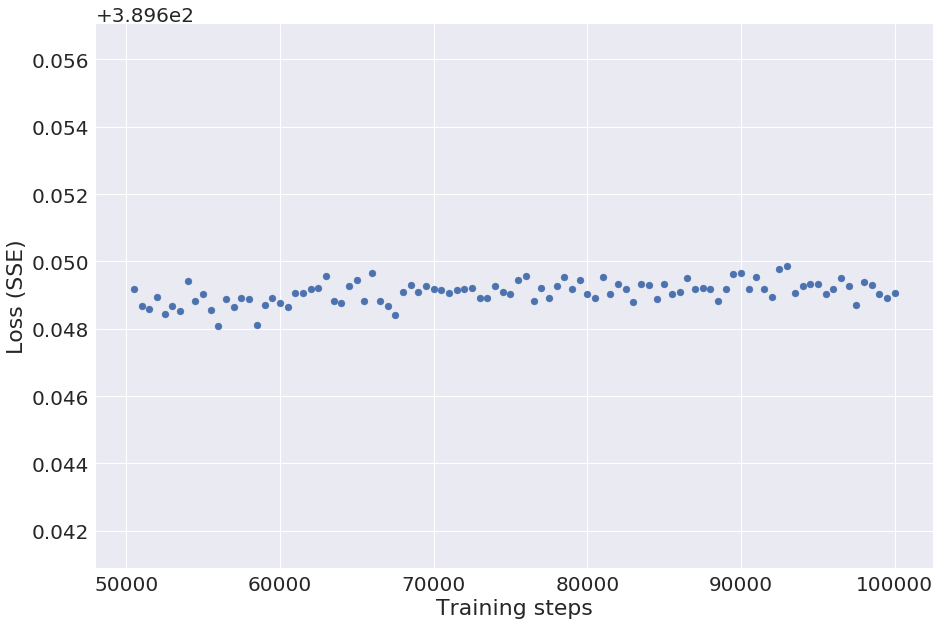

In [91]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [92]:
predictions = classifier.predict(
    input_fn=lambda:eval_input_fn(X_test,labels=None,
    batch_size=batch_size))

In [93]:
results = list(predictions)

def x(res,j):
    class_id = res[j]['class_ids'][0]
    probability = int(results[j]['probabilities'][class_id] *100)
    return ('%s%% probalitity to be class %d' % (probability,int(class_id)))
    
print ('Predictions for 10 first records on test(dataset):')

for i in range(0,10):    
    print (x(results,i))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Predictions for 10 first records on test(dataset):
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0


In [94]:
predictions = np.array([p['class_ids'][0] for p in results])

In [95]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [96]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.00
The Mean Absolute Error: 0.52 
The Median Absolute Error: 0.00 


In [97]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [98]:
predictions.size

1386

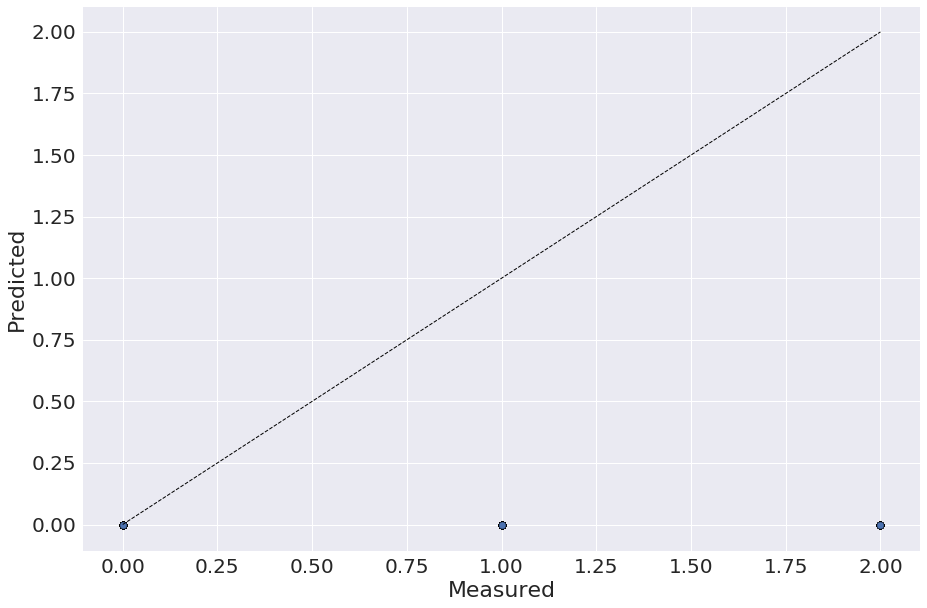

In [99]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()